In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load fraud data and IP geolocation data
fraud_df = pd.read_csv('/content/drive/MyDrive/week 8/Data/Fraud_Data.csv')
ip_df = pd.read_csv('/content/drive/MyDrive/week 8/Data/IpAddress_to_Country.csv')

# Preview top rows
fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
# Check and drop missing values
print(fraud_df.isnull().sum())
fraud_df.dropna(inplace=True)


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


In [ ]:
# Remove duplicates and convert types
fraud_df.drop_duplicates(inplace=True)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['age'] = fraud_df['age'].astype(int)


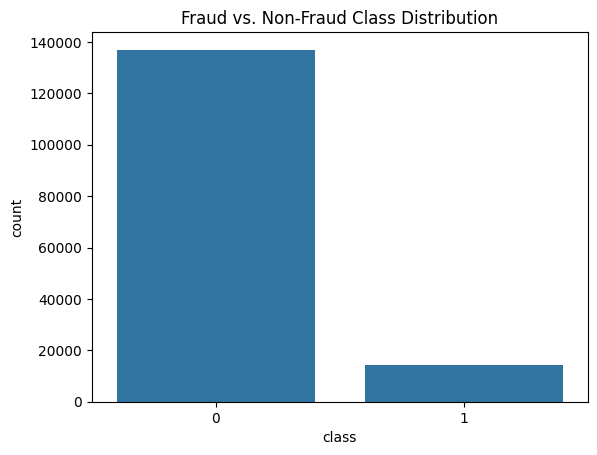

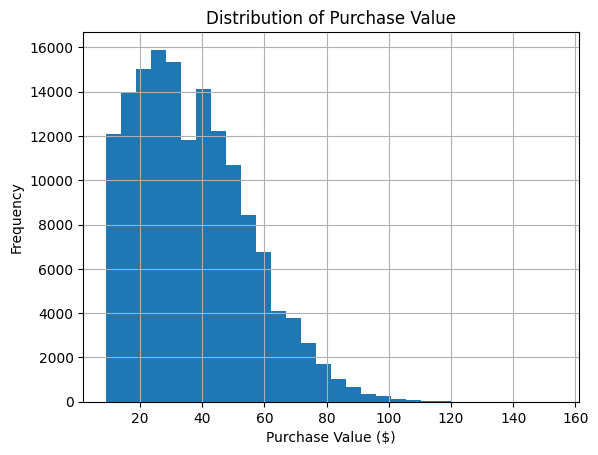

In [ ]:
# Class distribution
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs. Non-Fraud Class Distribution")
plt.show()

# Purchase value distribution
fraud_df['purchase_value'].hist(bins=30)
plt.title("Distribution of Purchase Value")
plt.xlabel("Purchase Value ($)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Convert IP addresses to integers
def ip_to_int(ip_str):
    return int(ipaddress.ip_address(ip_str))

fraud_df['ip_int'] = fraud_df['ip_address'].astype(int).apply(ip_to_int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int).apply(ip_to_int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int).apply(ip_to_int)

In [ ]:
# Map IP to country
def map_country(ip):
    match = ip_df[(ip_df['lower_bound_ip_address'] <= ip) & (ip_df['upper_bound_ip_address'] >= ip)]
    return match['country'].values[0] if not match.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_int'].apply(map_country)


In [ ]:
# Time-based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 60

# Transaction count per user
txn_count = fraud_df.groupby('user_id').size().reset_index(name='txn_count')
fraud_df = fraud_df.merge(txn_count, on='user_id', how='left')
